## Collaborative Filter - Netflix Prize Data

Prepared for Manel Khan

In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# requires Fast.ai library, available at https://github.com/fastai/fastai
# works best on a GPU; there is a cpu version, but this code
# was tested on the GPU version using a Paperspace instance.
from fastai.learner import *
from fastai.column_data import *
import csv

In [23]:
#path to directory containing data
path = 'data/manel_khan/'

In [ ]:
# read in data as pandas dataframe
ratings = pd.read_csv(path+'all_ratings.csv')
ratings.head()

In [ ]:
# sort values by user_id
ratings.sort_values(['user_id'], inplace=True)
ratings.head()

In [ ]:
# toal number of users and ratings
len(ratings.user_id.unique()), ratings.shape[0]

In [ ]:
# save sorted dataframe to csv
ratings.to_csv(path+'ratings_sorted.csv', index=False)

In [ ]:
# read in sorted csv as dataframe
ratings = pd.read_csv(path+'ratings_sorted.csv')

In [ ]:
# create sample
sample_ratings = ratings.iloc[:1000000]
sample_ratings.head()

In [ ]:
# save sample to csv
sample_ratings.to_csv(path+'sample_ratings.csv', index = False)

In [24]:
# read in sample as dataframe
sample_ratings = pd.read_csv(path+'sample_ratings.csv')
sample_ratings.head()

,movie_id,user_id,rating
0,17324,6,3
1,7040,6,3
2,16605,6,4
3,3608,6,4
4,6099,6,5


Just for display purposes, let's read in the movie names too.

In [25]:
sample_ratings.isnull().values.any()

False

In [27]:
len(sample_ratings.movie_id.unique()), len(sample_ratings.user_id.unique())

(16218, 4666)

In [28]:
# movies csv to dataframe (Movie titles containing commas truncated for now)
movies = pd.read_csv(path+'movie_titles_1.csv')
movies = movies[['movie_id','Year','Title']].copy()
movies.head()

,movie_id,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


## Collaborative filtering

In [5]:
val_idxs = get_cv_idxs(len(sample_ratings)) # indexes for validation set
wd=1e-5 # weight-decay
n_factors = 50 # number of embeddings

In [6]:
# sets data and learner model - a lot happening behind the scenes here
# see fastai/column_data.py & fastai/learner.py for details
cf = CollabFilterDataset.from_csv(path, 'sample_ratings.csv', 'user_id', 'movie_id', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [ ]:
# find optimal learning rate (see plot below)
learn.lr_find()

In [ ]:
# optimal learning rate is lowest number where curve is clearly going down, here 1e-4
learn.sched.plot()

In [ ]:
# the lower the loss, the better the model
learn.fit(1e-3, 1, wds=wd, cycle_len=5, use_clr_beta=(5,20,0.95,0.75))

To get [RMSE](http://www.statisticshowto.com/rmse/), we'll need to take the square root of our loss, which is plain MSE (Mean Squared Error). I don't have benchmark data on the Netflix dataset. The benchmark for the Movielens data was 0.91

In [ ]:
# get RMSE - surprisingly val_loss was better on the 1% sample than the 10% sample
math.sqrt(0.747) # on 1% of dataset
#math.sqrt(0.846) # on 10% of dataset

In [ ]:
# save the weights from the finished model
learn.save('subset_1p') #subset 1%

In [7]:
# load the weights
learn.load('subset_1p')

In [11]:
# get predictions - here we are getting predictions on the validation set
preds = learn.predict()

In [ ]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [ ]:
new_data = np.array(18001, cf.items[0])

In [ ]:
new_data = torch.from_numpy(new_data)
new_data = new_data.cuda()
new_data = Variable(new_data)
new_data = new_data.long()
blankconts = torch.from_numpy(np.zeros(1))
blankconts = Variable(blankconts.cuda())
blankconts = blankconts.long()

In [ ]:
learn.data.val_y.reshape(-1)
learn.data.val_y

In [ ]:
m = learn.model
m.eval()

## Analyze results

### Movie bias

This section provides the way to retrieve recommendations. There are two types of lists below: one for overall highest and lowest rated movies (or shows), and one for movies by category (or embedding). Unfortunately, because the data only contains ratings, we don't currently have good definitions for the categories. Nevertheless, the algorithm has detected some type of connection in these movies based on user preferences. 

Here is one way to use this information. For a user, present them with a few lists based on the different types shown below. For example, you could always present users with a list of the highest rated movies overall (separating out the ones that viewer had viewed on your system.) Then present them with a list containing a few top rated and low rated from each category. (See embedding interpretation below, which in this example only lists two categories, but there are 50 total categories, or embeddings.)

Then you would want some way to track ratings provided by the user as well as their watching history. You could ask them directly to rate movies, which is how Netflix used to handle it and how [Movielens](https://movielens.org/) handles it now. (My understanding is that Movielens was the research that Netflix used for their initial algorithm, but not certain about that.) Or you could do something like give weighted ratings to movies they chose to watch based on things such as, did they watch all the way through, have they watched similar movies before, etc.

Regardless of how you do it, you would add all new users to your database and each time you got a new rating on the user, you would update their entry in the database.

You would then retrain your model periodically, say once every evening, to update recommendations based on the users new ratings.

In [8]:
movie_names = movies.set_index('movie_id')['Title'].to_dict()
g=sample_ratings.groupby('movie_id')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [65]:
m=learn.model; m.cuda() # cuda() puts it on the GPU

EmbeddingDotBias(
  (u): Embedding(4666, 50)
  (i): Embedding(16218, 50)
  (ub): Embedding(4666, 1)
  (ib): Embedding(16218, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [82]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [83]:
movie_bias

array([[ 0.04897],
       [ 0.4301 ],
       [ 0.3891 ],
       ...,
       [-0.18556],
       [ 0.25064],
       [ 0.06926]], dtype=float32)

In [84]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [86]:
# Overall top rated movies
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.285652,
  'The Lord of the Rings: The Fellowship of the Ring: Extended Edition'),
 (1.2448416, 'The Shawshank Redemption: Special Edition'),
 (1.1919568, 'Lord of the Rings: The Two Towers: Extended Edition'),
 (1.1755052, 'Lord of the Rings: The Return of the King: Extended Edition'),
 (1.0958456, '24: Season 1'),
 (1.0514416, 'Lost: Season 1'),
 (1.0285147, '24: Season 3'),
 (1.0155619, '24: Season 2'),
 (1.0095052, 'The Sopranos: Season 2'),
 (0.9983973, 'Finding Nemo (Widescreen)'),
 (0.9549404, 'The Godfather'),
 (0.94233835, 'Band of Brothers'),
 (0.9226732, 'Shrek (Full-screen)'),
 (0.9126036, 'Seinfeld: Season 4'),
 (0.91236794, 'Seinfeld: Season 3')]

In [85]:
# Bottom rate movies
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.6249363, 'Gigli'),
 (-0.5721485, 'Birth'),
 (-0.51279885, 'Full Frontal'),
 (-0.512489, 'Battlefield Earth'),
 (-0.4987886, 'The Blair Witch Project'),
 (-0.49404448, 'The Real Cancun'),
 (-0.47506443, 'Punch-Drunk Love'),
 (-0.47201887, 'In the Cut'),
 (-0.47094148, 'Speed 2: Cruise Control'),
 (-0.4664452, 'Cop and a Half'),
 (-0.46310356, "Look Who's Talking Too"),
 (-0.449463, 'Solaris'),
 (-0.43183392, 'Dr. T & the Women'),
 (-0.43164447, 'Fear Dot Com'),
 (-0.42341313, 'Dumb and Dumberer: When Harry Met Lloyd')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [87]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [89]:
movie_pca.shape

(3, 3000)

In [90]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

The next two cells compares different movies according to the 1st component. Since the model just interpreted these from the ratings, you have to kind of guess at what the component is. This one seems to be something like 'dialog-driven vs. action'.

In [91]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.030628404, 'Dogville'),
 (0.029855572, 'House of the Dead'),
 (0.028271262, 'A Dirty Shame'),
 (0.027520465, 'Birth'),
 (0.027499147, 'Full Frontal'),
 (0.02658904, 'Gigli'),
 (0.025919093, 'Northfork'),
 (0.025175285, 'Punch-Drunk Love'),
 (0.024872184, 'Down by Law'),
 (0.02447841, 'I Heart Huckabees')]

In [92]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.061105847, 'Friends: The Series Finale'),
 (-0.05795087, 'Lord of the Rings: The Return of the King'),
 (-0.05728614, 'Sex and the City: Season 3'),
 (-0.056470715, 'Sex and the City: Season 2'),
 (-0.055565093, 'The Best of Friends: Season 1'),
 (-0.055215485, 'The Shawshank Redemption: Special Edition'),
 (-0.05368456, 'Friends: Season 4'),
 (-0.052445725, 'Friends: Season 1'),
 (-0.05243055, 'Raiders of the Lost Ark'),
 (-0.051834688, 'The Lion King: Special Edition')]

In [93]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component.

In [94]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.05827615, 'Pearl Harbor'),
 (0.052898996, "Look Who's Talking Now"),
 (0.04985066, 'Armageddon'),
 (0.049850464, 'Maid in Manhattan'),
 (0.04857209, 'How to Lose a Guy in 10 Days'),
 (0.04821224, 'The Wedding Planner'),
 (0.047354992, 'Catwoman'),
 (0.047273904, 'The Fast and the Furious'),
 (0.046562552, 'Coyote Ugly'),
 (0.04565226, 'Gone in 60 Seconds')]

In [95]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.051720567, 'Eternal Sunshine of the Spotless Mind'),
 (-0.050828137, 'The Royal Tenenbaums'),
 (-0.050689492, 'Memento'),
 (-0.050265793, 'Pulp Fiction'),
 (-0.049813297, 'Lost in Translation'),
 (-0.04772519, 'Dr. Strangelove'),
 (-0.046974305, 'The Office Special'),
 (-0.045323737, 'Monty Python and the Holy Grail'),
 (-0.044915974, 'Being John Malkovich'),
 (-0.044807382, 'The Simpsons: Season 4')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

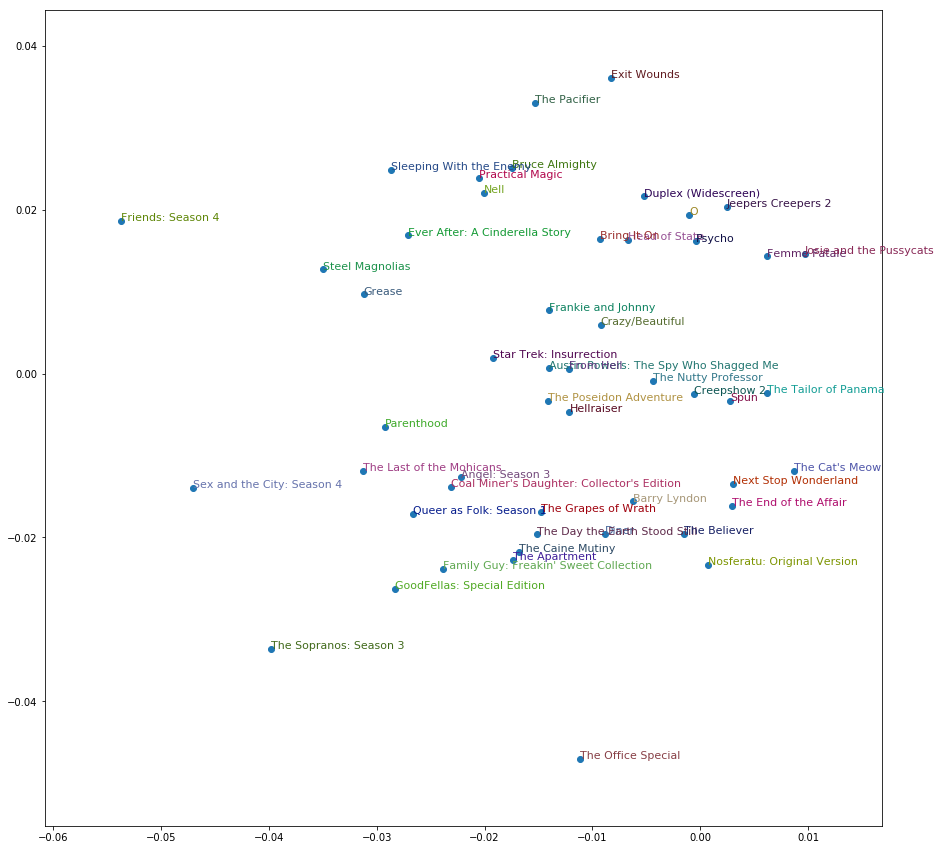

In [96]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()